In [43]:
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet', drop_connect_rate=0.4)

In [44]:
'''
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Convolution2D
from keras import utils
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from PIL import Image
import os*
'''

import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0

import os

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = None

In [45]:
data_path = "/content/drive/MyDrive/archive"
train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "val")

In [46]:
ds_train, ds_val = keras.utils.image_dataset_from_directory(train_path, image_size = (IMG_SIZE, IMG_SIZE), batch_size = BATCH_SIZE, crop_to_aspect_ratio=True, validation_split=0.2, subset = "both", seed = 1337)
ds_test = keras.utils.image_dataset_from_directory(test_path, image_size = (IMG_SIZE, IMG_SIZE), batch_size = BATCH_SIZE, crop_to_aspect_ratio=True)
NUM_CLASSES = 10

Found 1400 files belonging to 10 classes.
Using 1120 files for training.
Using 280 files for validation.
Found 200 files belonging to 10 classes.


In [47]:
'''
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))
'''

'\nsize = (IMG_SIZE, IMG_SIZE)\nds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))\nds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))\n'

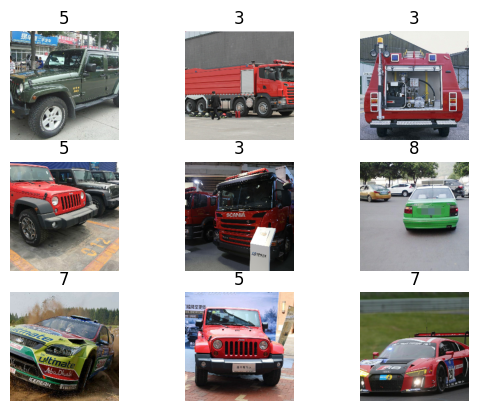

In [48]:
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(label))
    plt.axis("off")

In [49]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

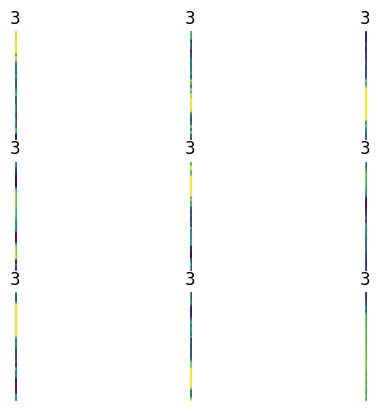

In [50]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(image.numpy())
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.title("{}".format(label))
        plt.axis("off")

In [51]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

BATCH_SIZE = 32

ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [53]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=NUM_CLASSES,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()


Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 224, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_5[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv_pad (ZeroPadding  (None, 225, 225, 3)          0         ['normalization_3

In [54]:
epochs = 40  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)

Epoch 1/40
35/35 [==============================] - 158s 3s/step - loss: 3.8951 - accuracy: 0.0991 - val_loss: 2.4349 - val_accuracy: 0.1042
Epoch 2/40
35/35 [==============================] - 35s 537ms/step - loss: 3.1170 - accuracy: 0.1384 - val_loss: 2.3720 - val_accuracy: 0.1042
Epoch 3/40
35/35 [==============================] - 34s 570ms/step - loss: 2.7388 - accuracy: 0.1937 - val_loss: 2.5124 - val_accuracy: 0.0990
Epoch 4/40
35/35 [==============================] - 36s 613ms/step - loss: 2.5662 - accuracy: 0.2116 - val_loss: 2.6991 - val_accuracy: 0.0833
Epoch 5/40
35/35 [==============================] - 37s 609ms/step - loss: 2.3514 - accuracy: 0.2500 - val_loss: 2.7705 - val_accuracy: 0.1042
Epoch 6/40
35/35 [==============================] - 37s 625ms/step - loss: 2.3056 - accuracy: 0.2750 - val_loss: 2.9748 - val_accuracy: 0.0938
Epoch 7/40
35/35 [==============================] - 34s 574ms/step - loss: 2.2765 - accuracy: 0.2759 - val_loss: 3.4406 - val_accuracy: 0.0990
E

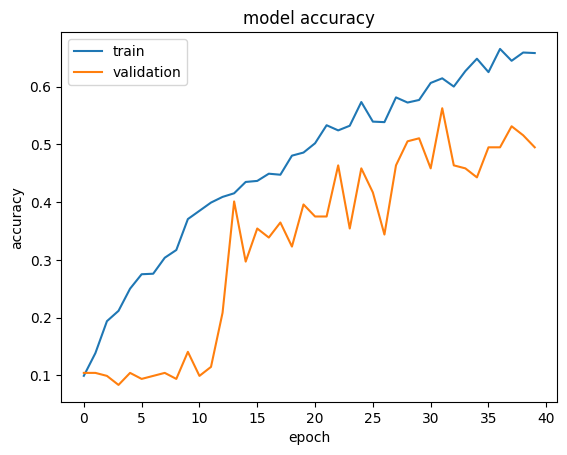

In [55]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [56]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/25
35/35 [==============================] - 41s 522ms/step - loss: 1.6176 - accuracy: 0.6161 - val_loss: 0.7878 - val_accuracy: 0.7448
Epoch 2/25
35/35 [==============================] - 30s 401ms/step - loss: 0.9839 - accuracy: 0.7705 - val_loss: 0.6501 - val_accuracy: 0.7448
Epoch 3/25
35/35 [==============================] - 30s 400ms/step - loss: 0.8446 - accuracy: 0.7982 - val_loss: 0.5279 - val_accuracy: 0.8073
Epoch 4/25
35/35 [==============================] - 30s 443ms/step - loss: 0.9042 - accuracy: 0.8009 - val_loss: 0.6133 - val_accuracy: 0.7865
Epoch 5/25
35/35 [==============================] - 31s 430ms/step - loss: 0.7734 - accuracy: 0.8286 - val_loss: 0.5520 - val_accuracy: 0.8438
Epoch 6/25
35/35 [==============================] - 32s 440ms/step - loss: 0.7761 - accuracy: 0.8161 - val_loss: 0.6881 - val_accuracy: 0.8177
Epoch 7/25
35/35 [==============================] - 32s 501ms/step - loss: 0.

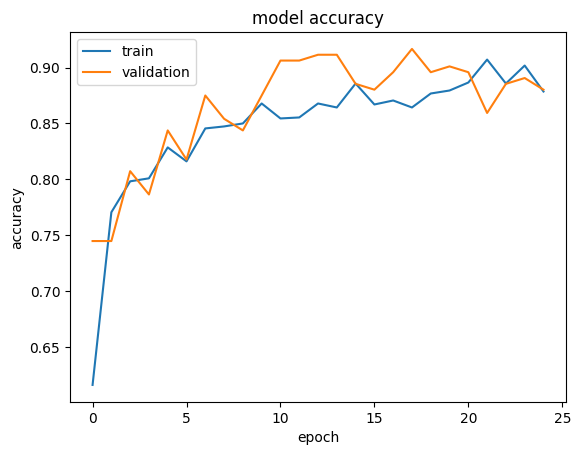

In [57]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)

Epoch 1/4
35/35 [==============================] - 42s 528ms/step - loss: 0.4978 - accuracy: 0.8946 - val_loss: 0.6702 - val_accuracy: 0.8958
Epoch 2/4
35/35 [==============================] - 30s 408ms/step - loss: 0.4030 - accuracy: 0.9107 - val_loss: 0.6919 - val_accuracy: 0.8958
Epoch 3/4
35/35 [==============================] - 32s 524ms/step - loss: 0.3797 - accuracy: 0.9205 - val_loss: 0.6472 - val_accuracy: 0.8958
Epoch 4/4
35/35 [==============================] - 32s 450ms/step - loss: 0.3638 - accuracy: 0.9107 - val_loss: 0.5959 - val_accuracy: 0.9115


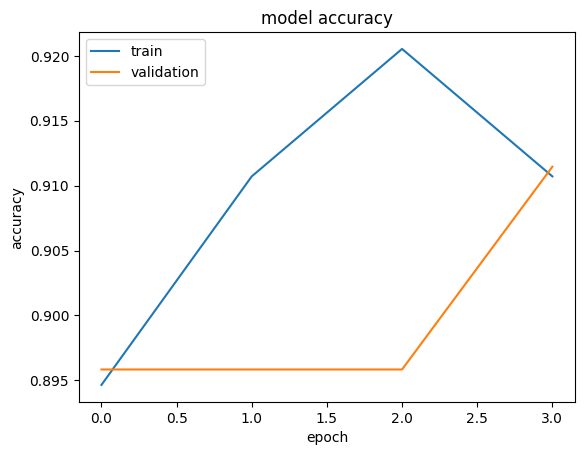

In [58]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 4  # @param {type: "slider", min:4, max:10}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)